<a href="https://colab.research.google.com/github/annisasuciati/Hate-Speech-Detection/blob/master/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [310]:
pip install PySastrawi

In [311]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix

import warnings 
warnings.filterwarnings("ignore")
import unidecode
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
import plotly.express as px
from collections import Counter
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Dataset

In [312]:
df = pd.read_csv('https://raw.githubusercontent.com/annisasuciati/Hate-Speech-Detection/master/IDHSD_RIO_unbalanced_713_2017.txt', sep='\t', encoding = "ISO-8859-1", dtype=str)
df.head()

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


In [313]:
# pip install Unidecode

# Melakukan drop terhadap data yang duplikat

In [314]:
df.shape

(713, 2)

In [315]:
df.drop_duplicates(inplace = True)

In [316]:
df.shape

(703, 2)

# Mencari dataset dengan nilai kosong

In [317]:
df['Tweet'].isna().sum()

0

In [318]:
df['Label'].isna().sum()

0

# Menghilangkan '@'

In [319]:
#Code to remove @
df['clean_tweet'] = df['Tweet'].apply(lambda x : ' '.join([tweet for tweet in x.split()if not tweet.startswith("@")]))

In [320]:
df.head()

,Label,Tweet,clean_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,RT Fadli Zon Minta Mendagri Segera Menonaktifk...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,RT Mereka terus melukai aksi dalam rangka meme...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,RT Waspada KTP palsu.....kawal PILKADA https:\...


# Menghilangkan angka

In [321]:
#Removing numbers
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([tweet for tweet in x.split() if not tweet == '\d*']))

In [322]:
df.head()

,Label,Tweet,clean_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,RT Fadli Zon Minta Mendagri Segera Menonaktifk...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,RT Mereka terus melukai aksi dalam rangka meme...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,RT Waspada KTP palsu.....kawal PILKADA https:\...


# Menhilangkan greek character

In [323]:
#Removing all the greek characters using unidecode library
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()])) 

In [324]:
df.head(10)

,Label,Tweet,clean_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,RT Fadli Zon Minta Mendagri Segera Menonaktifk...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,RT Mereka terus melukai aksi dalam rangka meme...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,RT Waspada KTP palsu.....kawal PILKADA https:\...
5,Non_HS,@felixsiauw masih bnyak hal agamis yg bisa dib...,"masih bnyak hal agamis yg bisa dibahas, kenapa..."
6,Non_HS,@saidaqil apa maksud pernyataan. Anda? Apa and...,apa maksud pernyataan. Anda? Apa anda mengamin...
7,Non_HS,Ahok Akan Integrasikan Transportasi Publik den...,Ahok Akan Integrasikan Transportasi Publik den...
8,Non_HS,"Ahok mampu melawan korupsi di ibukota, bangun ...","Ahok mampu melawan korupsi di ibukota, bangun ..."
9,Non_HS,"Awasi Kecurangan Pilkada, Agus - Sylvi Pakai A...","Awasi Kecurangan Pilkada, Agus - Sylvi Pakai A..."


# Menghilangkan kata hmm dan lainnya

In [325]:
#Removing the word 'hmm' and it's variants
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))

In [326]:
df.head()

,Label,Tweet,clean_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,RT Fadli Zon Minta Mendagri Segera Menonaktifk...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,RT Mereka terus melukai aksi dalam rangka meme...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...","Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,RT Waspada KTP palsu.....kawal PILKADA https:\...


In [327]:
import string
# Menghapus mention, link dan hastag
def remove_mention(tweet):
  rem_mt = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", tweet).split())
  return rem_mt

# Menghapus URL
def remove_url(tweet):
  rem_url = re.sub(r"http\S+", "", tweet)
  return rem_url

# Menghapus RT
def remove_RT(tweet):
  rem_RT = re.sub(r'^RT[\s]+', '', tweet)
  return rem_RT

# Menghapus tanda baca
def remove_punctuation(tweet):
  rem_punct  = tweet.translate(str.maketrans("","",string.punctuation))
  return rem_punct

In [328]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", x).split()))
df['clean_tweet'] = df['clean_tweet'].apply(remove_url)           # function remove_url

In [329]:
df['clean_tweet'] = df['clean_tweet'].apply(remove_RT)            # function remove_RT

In [330]:
df['clean_tweet'] = df['clean_tweet'].apply(remove_punctuation)   # function remove_punctuation

In [331]:
df.head()

,Label,Tweet,clean_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,Fadli Zon Minta Mendagri Segera Menonaktifkan ...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,Mereka terus melukai aksi dalam rangka memenja...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi bagaimana gurbernur melakukan kekerasan ...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Ahmad Dhani Tak Puas Debat Pilkada Masalah Jal...
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,Waspada KTP palsukawal PILKADA


In [334]:
#Removing stopwords
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('indonesian'))]))

In [335]:
# nltk.download('stopwords')

In [336]:
df.head()

,Label,Tweet,clean_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,Fadli Zon Minta Mendagri Segera Menonaktifkan ...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,Mereka melukai aksi rangka memenjarakan Ahok A...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi gurbernur kekerasan perempuan Buktinya i...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Ahmad Dhani Tak Puas Debat Pilkada Masalah Jal...
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,Waspada KTP palsukawal PILKADA


In [337]:
#Lemmitization
lemmatizer = WordNetLemmatizer()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [338]:
#Stemming
ps = PorterStemmer()
adwait = df
#adwait.head()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

In [339]:
df.head()

,Label,Tweet,clean_tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,fadli zon minta mendagri segera menonaktifkan ...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...,mereka melukai aksi rangka memenjarakan ahok a...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...,sylvi gurbernur kekerasan perempuan buktinya i...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",ahmad dhani tak pua debat pilkada masalah jala...
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,waspada ktp palsukaw pilkada


In [340]:
# print(df.iloc[711,:])

In [341]:
#Tokenization
corpus = []
for i in df.index:
    # print(i)
    tweet = df['clean_tweet'][i]
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('indonesian'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)
    # print('done')

In [342]:
#Ensuring all the tweets are tokenized into individual words
len(corpus)

703

In [343]:
corpus

['fadli zon mendagri menonaktifkan ahok gubernur dki',
 'melukai aksi rangka memenjarakan ahok ahok gagal pilkada',
 'sylvi gurbernur kekerasan perempuan buktinya ibu2 foto bareng',
 'ahmad dhani pua debat pilkada jalan bekasi terungkap',
 'waspada ktp palsukaw pilkada',
 'bnyak agami yg dibaha pilkada tingkat keimanan sebata pilkada',
 'maksud pernyataan mengaminkan kriminalisasi ahok hati2 jg dg mulutmu',
 'ahok integrasikan transportasi publik sistem singl ticketingu2026',
 'ahok melawan korupsi ibukota bangun infrastruktur mencoba memperbaiki trobosan work well',
 'awasi kecurangan pilkada agu sylvi pakai aplikasi',
 'gak jokowi ahok kalem melengkapi',
 'bo makan istana ga undang noh makan istana gebang tapinya',
 'cuti habi ahok gubernur dki pengamat mengadaada republika onlin',
 'debat pilkada dki jakarta digelar jumat malam',
 'demonstran fpd malteng desak bawaslu hentikan tahapan pilkada maluku',
 'didesak berhentikan ahok ngele cuti pilkada kampani habi kemendagri raguragu',
 

In [344]:
def tf_idf(data):
  vectorizer = TfidfVectorizer()
  return vectorizer.fit_transform(data)

In [345]:
Label = pd.DataFrame(data=df, columns=['Label'])
X_train, X_test, y_train, y_test = train_test_split(df['clean_tweet'], Label, test_size=0.25, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(527,)
(176,)
(527, 1)
(176, 1)


In [346]:
lb_make = LabelEncoder()
y_train = lb_make.fit_transform(y_train)
print(y_train.shape)

(527,)


In [347]:
y_test = lb_make.fit_transform(y_test)
print(y_test.shape)

(176,)


In [348]:
# Feature Extraction
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

X_train = vectorizer.transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

In [349]:
# Modeling Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Predict to Test Data
y_pred_rf= rf.predict(X_test)

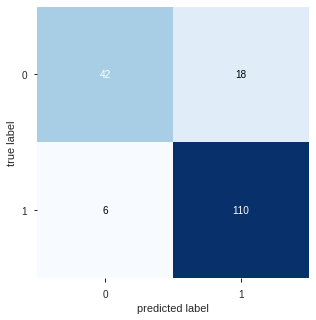

In [350]:
# Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [351]:
# Print Classification Report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        60
           1       0.86      0.95      0.90       116

    accuracy                           0.86       176
   macro avg       0.87      0.82      0.84       176
weighted avg       0.86      0.86      0.86       176



In [352]:
# Show the Accuracy, Precision, Recall
acc_rf = metrics.accuracy_score(y_test, y_pred_rf)
prec_rf = metrics.precision_score(y_test, y_pred_rf)
rec_rf = metrics.recall_score(y_test, y_pred_rf)
f1_rf = metrics.f1_score(y_test, y_pred_rf)
kappa_rf = metrics.cohen_kappa_score(y_test, y_pred_rf)

print("Accuracy:", acc_rf)
print("Precision:", prec_rf)
print("Recall:", rec_rf)
print("F1 Score:", f1_rf)
print("Cohens Kappa Score:", kappa_rf)

Accuracy: 0.8636363636363636
Precision: 0.859375
Recall: 0.9482758620689655
F1 Score: 0.9016393442622951
Cohens Kappa Score: 0.681159420289855


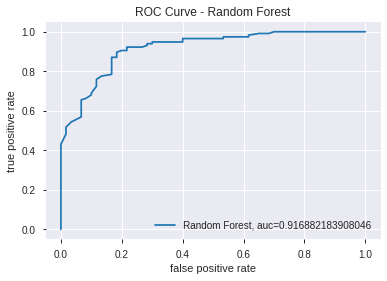

In [353]:
# ROC Curve
y_pred_rf_proba = rf.predict_proba(X_test)[::,1]
fprrf, tprrf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
aucrf = metrics.roc_auc_score(y_test, y_pred_rf_proba)
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))
plt.title('ROC Curve - Random Forest')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

In [354]:
# Modeling Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predict to Test Data
y_pred_gnb= gnb.predict(X_test)

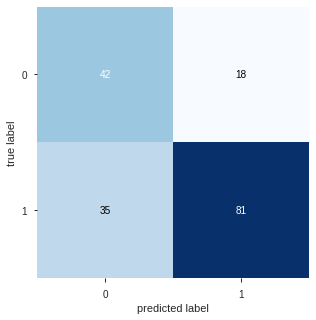

In [355]:
# Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_gnb)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [356]:
# Print Classification Report
print(classification_report(y_test, y_pred_gnb))

              precision    recall  f1-score   support

           0       0.55      0.70      0.61        60
           1       0.82      0.70      0.75       116

    accuracy                           0.70       176
   macro avg       0.68      0.70      0.68       176
weighted avg       0.73      0.70      0.71       176



In [357]:
# Show the Accuracy, Precision, Recall
acc_gnb = metrics.accuracy_score(y_test, y_pred_gnb)
prec_gnb = metrics.precision_score(y_test, y_pred_gnb)
rec_gnb = metrics.recall_score(y_test, y_pred_gnb)
f1_gnb = metrics.f1_score(y_test, y_pred_gnb)
kappa_gnb = metrics.cohen_kappa_score(y_test, y_pred_gnb)

print("Accuracy:", acc_gnb)
print("Precision:", prec_gnb)
print("Recall:", rec_gnb)
print("F1 Score:", f1_gnb)
print("Cohens Kappa Score:", kappa_gnb)

Accuracy: 0.6988636363636364
Precision: 0.8181818181818182
Recall: 0.6982758620689655
F1 Score: 0.7534883720930233
Cohens Kappa Score: 0.3727810650887574


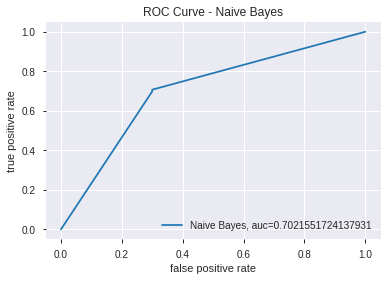

In [358]:
# ROC Curve
y_pred_gnb_proba = gnb.predict_proba(X_test)[::,1]
fprgnb, tprgnb, _ = metrics.roc_curve(y_test,  y_pred_gnb_proba)
aucgnb = metrics.roc_auc_score(y_test, y_pred_gnb_proba)
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.title('ROC Curve - Naive Bayes')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

In [359]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
# y_pred_svm

In [360]:
# Show the Accuracy, Precision, Recall
acc_svm = metrics.accuracy_score(y_test, y_pred_svm)
prec_svm = metrics.precision_score(y_test, y_pred_svm)
rec_svm = metrics.recall_score(y_test, y_pred_svm)
f1_svm = metrics.f1_score(y_test, y_pred_svm)
kappa_svm = metrics.cohen_kappa_score(y_test, y_pred_svm)

print("Accuracy:", acc_svm)
print("Precision:", prec_svm)
print("Recall:", rec_svm)
print("F1 Score:", f1_svm)
print("Cohens Kappa Score:", kappa_svm)

Accuracy: 0.8636363636363636
Precision: 0.8538461538461538
Recall: 0.9568965517241379
F1 Score: 0.9024390243902438
Cohens Kappa Score: 0.6784409257003654


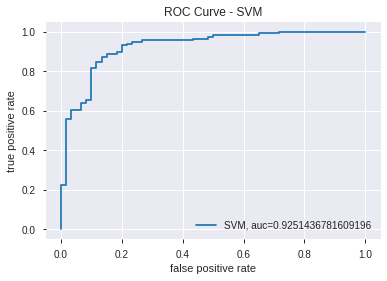

In [361]:
# ROC Curve
y_pred_svm_proba = svm.predict_proba(X_test)[::,1]
fprsvm, tprsvm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba)
aucsvm = metrics.roc_auc_score(y_test, y_pred_svm_proba)
plt.plot(fprsvm,tprsvm,label="SVM, auc="+str(aucsvm))
plt.title('ROC Curve - SVM')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

In [362]:
# Modeling KNN
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

# Predict to Test Data
y_pred_knn= knn.predict(X_test)

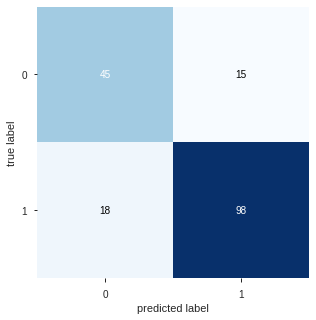

In [363]:
# Show the Confussion Matrix
cm2 = metrics.confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm2, figsize=(5,5))
plt.show()

In [364]:
# Print Classification Report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        60
           1       0.87      0.84      0.86       116

    accuracy                           0.81       176
   macro avg       0.79      0.80      0.79       176
weighted avg       0.82      0.81      0.81       176



In [365]:
# Show the Accuracy, Precision, Recall
acc_knn = metrics.accuracy_score(y_test, y_pred_knn)
prec_knn = metrics.precision_score(y_test, y_pred_knn)
rec_knn = metrics.recall_score(y_test, y_pred_knn)
f1_knn = metrics.f1_score(y_test, y_pred_knn)
kappa_knn = metrics.cohen_kappa_score(y_test, y_pred_knn)

print("Accuracy:", acc_knn)
print("Precision:", prec_knn)
print("Recall:", rec_knn)
print("F1 Score:", f1_knn)
print("Cohens Kappa Score:", kappa_knn)

Accuracy: 0.8125
Precision: 0.8672566371681416
Recall: 0.8448275862068966
F1 Score: 0.8558951965065502
Cohens Kappa Score: 0.5877342419080068


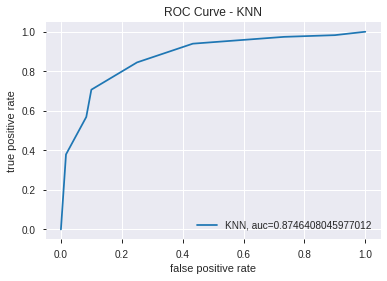

In [366]:
# ROC Curve
y_pred_knn_proba = knn.predict_proba(X_test)[::,1]
fprknn, tprknn, _ = metrics.roc_curve(y_test,  y_pred_knn_proba)
aucknn = metrics.roc_auc_score(y_test, y_pred_knn_proba)
plt.plot(fprknn,tprknn,label="KNN, auc="+str(aucknn))
plt.title('ROC Curve - KNN')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()

In [367]:

# Comparing Model Performance
print("Random Forest Accuracy =", acc_rf)
print("Random Forest Precision =", prec_rf)
print("Random Forest Recall =", rec_rf)
print("Random Forest F1-Score =", f1_rf)
print("_______________________")
print("Naive Bayes Accuracy =", acc_gnb)
print("Naive Bayes Precision =", prec_gnb)
print("Naive Bayes Recall =", rec_gnb)
print("Naive Bayes F1-Score =", f1_gnb)
print("_______________________")
print("SVM Accuracy =", acc_svm)
print("SVM Precision =", prec_svm)
print("SVM Recall =", rec_svm)
print("SVM F1-Score =", f1_svm)
print("_______________________")
print("KNN Accuracy =", acc_knn)
print("KNN Precision =", prec_knn)
print("KNN Recall =", rec_knn)
print("KNN F1-Score =", f1_knn)

Random Forest Accuracy = 0.8636363636363636
Random Forest Precision = 0.859375
Random Forest Recall = 0.9482758620689655
Random Forest F1-Score = 0.9016393442622951
_______________________
Naive Bayes Accuracy = 0.6988636363636364
Naive Bayes Precision = 0.8181818181818182
Naive Bayes Recall = 0.6982758620689655
Naive Bayes F1-Score = 0.7534883720930233
_______________________
SVM Accuracy = 0.8636363636363636
SVM Precision = 0.8538461538461538
SVM Recall = 0.9568965517241379
SVM F1-Score = 0.9024390243902438
_______________________
KNN Accuracy = 0.8125
KNN Precision = 0.8672566371681416
KNN Recall = 0.8448275862068966
KNN F1-Score = 0.8558951965065502


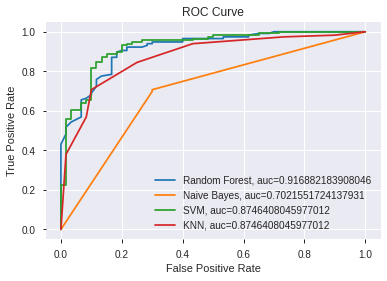

In [368]:
# Comparing ROC Curve
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))
plt.plot(fprgnb,tprgnb,label="Naive Bayes, auc="+str(aucgnb))
plt.plot(fprsvm,tprsvm,label="SVM, auc="+str(aucknn))
plt.plot(fprknn,tprknn,label="KNN, auc="+str(aucknn))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()